In [1]:
# Consolidated Imports
import os
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from google.colab import drive

In [2]:
# Consolidated Setup and Data Loading

# Mount Google Drive
drive.mount('/content/drive')

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Download FER2013
dataset_path = kagglehub.dataset_download('msambare/fer2013')
print(f"Dataset downloaded to: {dataset_path}")

# Paths
TRAIN_DIR = os.path.join(dataset_path, 'train')
TEST_DIR = os.path.join(dataset_path, 'test')

# Load data
emotion_map = {0: 0, 1: 0, 2: 0, 3: 2, 4: 0, 5: 2, 6: 1}  # neg=0, neu=1, pos=2
emotion_folders = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def load_data(data_dir, split='train'):
    data = []
    for emotion_idx, emotion in enumerate(emotion_folders):
        folder = os.path.join(data_dir, emotion)
        if os.path.exists(folder):
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                if os.path.isfile(img_path):
                    data.append({'image_path': img_path, 'sentiment': emotion_map[emotion_idx], 'usage': split})
        else:
            print(f"Warning: Folder {folder} not found.")
    return pd.DataFrame(data)

# Filter valid images
def filter_valid_images(df):
    valid_rows = []
    for idx, row in df.iterrows():
        try:
            img = Image.open(row['image_path']).convert('RGB')
            valid_rows.append(row)
        except:
            continue
    return pd.DataFrame(valid_rows)

train_df = load_data(TRAIN_DIR, 'train')
test_df = load_data(TEST_DIR, 'test')
train_df = filter_valid_images(train_df)
test_df = filter_valid_images(test_df)

print(f"Train size after filtering: {len(train_df)}, Test size after filtering: {len(test_df)}")
print("Train class distribution:\n", train_df['sentiment'].value_counts())
print("Test class distribution:\n", test_df['sentiment'].value_counts())

Mounted at /content/drive
Dataset downloaded to: /kaggle/input/fer2013
Train size after filtering: 28709, Test size after filtering: 7178
Train class distribution:
 sentiment
0    13358
2    10386
1     4965
Name: count, dtype: int64
Test class distribution:
 sentiment
0    3340
2    2605
1    1233
Name: count, dtype: int64


In [3]:
# Consolidated Dataset and DataLoader

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['sentiment']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
])
val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets
train_dataset = SentimentDataset(train_df, transform=train_transform)
test_dataset = SentimentDataset(test_df, transform=val_test_transform)

# Split train into train/val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create sampler for train_subset
train_indices = train_subset.indices
train_sentiments = [train_dataset.df.iloc[idx]['sentiment'] for idx in train_indices]
train_class_counts = pd.Series(train_sentiments).value_counts().sort_index()
train_class_weights = 1.0 / np.array([train_class_counts[i] for i in range(3)])
train_weights = [train_class_weights[label] for label in train_sentiments]
sampler = WeightedRandomSampler(train_weights, len(train_weights), replacement=True)

# DataLoaders
batch_size = 16  # Reduced for Colab Free
train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [4]:
# Consolidated Training and Validation Functions

# Training function with gradient accumulation
def train_epoch(model, loader, criterion, optimizer, device, scaler, accum_steps=2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels) / accum_steps
        scaler.scale(loss).backward()
        if (i + 1) % accum_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        running_loss += loss.item() * accum_steps
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        del images, labels, outputs
        torch.cuda.empty_cache()
    return running_loss / len(loader), correct / total

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                del images, labels, outputs
                torch.cuda.empty_cache()
    return running_loss / len(loader), correct / total

### ResNet-50 Model Configuration

Run the cell below to configure the notebook for training the ResNet-50 model.

In [5]:
# ResNet-50 Model Definition and Configuration

# Define the base directory for saving models
BASE_SAVE_DIR = '/content/drive/MyDrive/Models/Vision'
os.makedirs(BASE_SAVE_DIR, exist_ok=True) # Create directories if they don't exist

CHECKPOINT_PATH = os.path.join(BASE_SAVE_DIR, 'resnet50_fer2013_sentiment.pth')

# Model: ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3) # 3 classes for sentiment

# Freeze early layers (optional for ResNet)
# for name, param in model.named_parameters():
#     if 'layer1' in name or 'layer2' in name:
#         param.requires_grad = False

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Class weights for loss (using overall train_df)
class_weights = torch.tensor(1.0 / np.array([train_class_counts[i] for i in range(3)]), dtype=torch.float).to(device)
class_weights = class_weights / class_weights.sum() * 3.0

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Warmup scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, base_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.current_epoch = 0

    def step(self, epoch):
        self.current_epoch = epoch
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

# Mixed precision
scaler = torch.amp.GradScaler()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


### Training Loop

Run the cell below after configuring either the Swin-S or ResNet-50 model.

In [6]:
# Consolidated Training Loop with Early Stopping
num_epochs = 30
warmup_scheduler = WarmupScheduler(optimizer, warmup_epochs=7, base_lr=3e-5)
best_val_loss = float('inf')
patience = 5
counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # The model-specific unfreezing logic from the original cells is removed
    # as it might differ and is now managed within the model configuration cells.
    # If needed, add model-specific unfreezing logic back into the respective
    # model configuration cells or handle it within the training loop based on a flag.

    warmup_scheduler.step(epoch)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler, accum_steps=2)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/30 - Train Loss: 1.0163, Acc: 0.3335 | Val Loss: 1.1615, Acc: 0.1649
Epoch 2/30 - Train Loss: 0.9440, Acc: 0.3875 | Val Loss: 1.0480, Acc: 0.3617
Epoch 3/30 - Train Loss: 0.8386, Acc: 0.5285 | Val Loss: 0.9682, Acc: 0.4594
Epoch 4/30 - Train Loss: 0.7730, Acc: 0.6085 | Val Loss: 0.9122, Acc: 0.5394
Epoch 5/30 - Train Loss: 0.7185, Acc: 0.6616 | Val Loss: 0.8513, Acc: 0.6075
Epoch 6/30 - Train Loss: 0.6835, Acc: 0.6937 | Val Loss: 0.8378, Acc: 0.6289
Epoch 7/30 - Train Loss: 0.6551, Acc: 0.7244 | Val Loss: 0.8159, Acc: 0.6346
Epoch 8/30 - Train Loss: 0.6192, Acc: 0.7517 | Val Loss: 0.7672, Acc: 0.6952
Epoch 9/30 - Train Loss: 0.5918, Acc: 0.7759 | Val Loss: 0.7731, Acc: 0.7065
Epoch 10/30 - Train Loss: 0.5689, Acc: 0.7954 | Val Loss: 0.7863, Acc: 0.6991
Epoch 11/30 - Train Loss: 0.5488, Acc: 0.8064 | Val Loss: 0.7654, Acc: 0.7339
Epoch 12/30 - Train Loss: 0.5374, Acc: 0.8207 | Val Loss: 0.7737, Acc: 0.7276
Epoch 13/30 - Train Loss: 0.5151, Acc: 0.8350 | Val Loss: 0.7707, Acc: 0.

In [7]:
# Consolidated Evaluation

# Load best model
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.to(device)

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            for images, labels in loader:
                images = images.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
                del images, outputs
                torch.cuda.empty_cache()
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, precision, recall, f1, cm

test_acc, test_precision, test_recall, test_f1, cm = evaluate(model, test_loader, device)

print("\nTest Evaluation:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"Recall (macro): {test_recall:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")


Test Evaluation:
Accuracy: 0.7938
Precision (macro): 0.7629
Recall (macro): 0.7923
F1 Score (macro): 0.7712


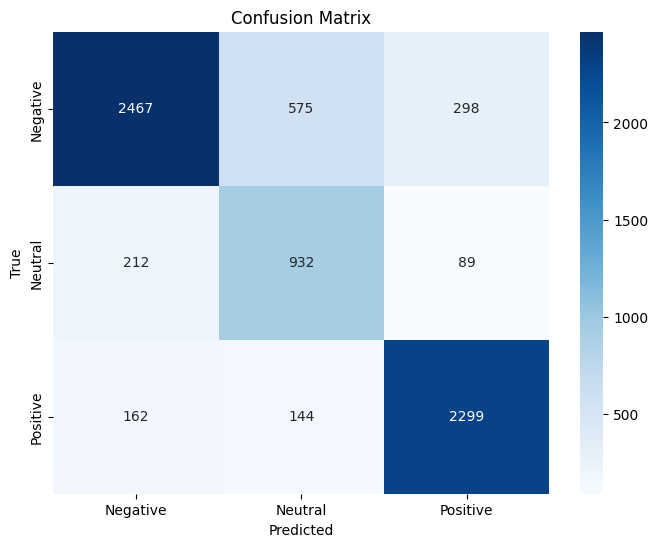

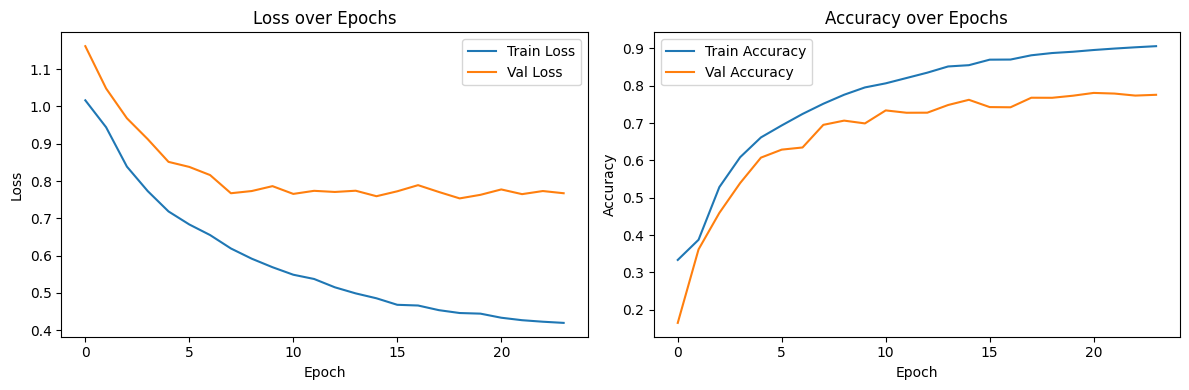

In [8]:
# Consolidated Plotting

# Plot confusion matrix
labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot metrics
epochs_range = range(len(train_losses))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [9]:
# Consolidated Saving and Inference

# Save final model
torch.save(model.state_dict(), CHECKPOINT_PATH.replace('.pth', '_final.pth'))

# Inference function
def predict_image(model, image_path, transform, device):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                output = model(image)
                _, predicted = output.max(1)
        return predicted.item()  # 0: neg, 1: neu, 2: pos
    except Exception as e:
        print(f"Error predicting {image_path}: {e}")
        return None